In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import pickle

from tqdm import tqdm
import regex as re

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score, make_scorer

from sklearn.linear_model import ElasticNetCV, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor, Booster

# TODO

- Fine tune models

In [23]:
# due to some version issues from the platform that I tuned the models
# !pip install scikit-learn==1.1.1
# !pip install xgboost==1.7.6

  Attempting uninstall: xgboost
    Found existing installation: xgboost 2.0.0
    Uninstalling xgboost-2.0.0:
      Successfully uninstalled xgboost-2.0.0


ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\erdem\\anaconda3\\Lib\\site-packages\\~gboost\\lib\\xgboost.dll'
Consider using the `--user` option or check the permissions.



In [2]:
train = pd.read_csv("datasets/main_ordinal_updated_train.csv")
test = pd.read_csv("datasets/main_ordinal_updated_test.csv")
# these were used in the platform that I fine-tuned the models
# train = pd.read_csv("/dbfs/FileStore/hakan/main_ordinal_updated_train.csv")
# test = pd.read_csv("/dbfs/FileStore/hakan/main_ordinal_updated_test.csv")

X_train = train.drop(columns=["price"])
X_test = test.drop(columns=["price"])

y_train = train["price"]
y_test = test["price"]

scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

print(f"Shape of the train set: {X_train.shape} {y_train.shape}")
print(f"Shape of the test set: {X_test.shape} {y_test.shape}")

Shape of the train set: (156544, 18) (156544,)
Shape of the test set: (39136, 18) (39136,)


C:\Users\erdem\anaconda3\lib\site-packages\sklearn\utils\validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\erdem\anaconda3\lib\site-packages\sklearn\utils\validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\erdem\anaconda3\lib\site-packages\sklearn\utils\validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\erdem\anaconda3\lib\site-packages\sklearn\utils\validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  i

In [3]:
def fine_tune(model, params, model_name, X_train, X_test, y_train, y_test, v=1):
    
    if model_name == "svr":
        grid_search = GridSearchCV(model, params, cv=2, scoring="neg_mean_squared_error", verbose=v)
    
    else:
        grid_search = GridSearchCV(model, params, scoring="neg_mean_squared_error", verbose=v)
    
    grid_search.fit(X_train, y_train)
    
    return grid_search.best_estimator_

In [4]:
models = [
    ElasticNet(),
    SVR(verbose=True),
    KNeighborsRegressor(),
    DecisionTreeRegressor(),
    RandomForestRegressor(),
    AdaBoostRegressor()
]

param_grids = {
    "elastic" : {
        'alpha': [0.1, 1.0, 3.0],
        'l1_ratio': [0.1, 0.5, 0.7, 0.9],
        'max_iter': [1000, 3000, 5000]
    },
    "svr" : {
        'kernel': ['linear', 'rbf', 'poly'],
        'C': [0.1, 1, 3]
    },
    "knn" : {
        'n_neighbors': [20, 30, 40, 50, 60, 70, 80]
    },
    "tree" : {
        'max_depth': [None, 5, 10, 15],
        'min_samples_split': [2, 3, 5],
        'min_samples_leaf': [1, 2, 4]
    },
    "rf" : {
        'n_estimators': [50, 100, 150, 200,],
        'max_depth': [None, 3, 5],
        'max_features':[3,5,7,9]
    },
    "ada" : {
        "n_estimators":[30, 40, 50, 60, 70],
        "learning_rate":[0.1, 0.3, 1, 2, 3]
    }
}

In [0]:
for idx, model_name in enumerate(param_grids):
    print(f"{model_name.upper()} started:")
    best_model = fine_tune(models[idx], param_grids[model_name], model_name, X_train, X_test, y_train, y_test) 
    
    joblib.dump(best_model, f"/dbfs/FileStore/hakan/best_{model_name}.joblib")

ELASTIC started:
Fitting 5 folds for each of 36 candidates, totalling 180 fits
SVR started:
Fitting 2 folds for each of 9 candidates, totalling 18 fits
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]KNN started:
Fitting 5 folds for each of 7 candidates, totalling 35 fits
TREE started:
Fitting 5 folds for each of 36 candidates, totalling 180 fits
RF started:
Fitting 5 folds for each of 48 candidates, totalling 240 fits


ADA started:
Fitting 5 folds for each of 25 candidates, totalling 125 fits
XGB started:
Fitting 5 folds for each of 225 candidates, totalling 1125 fits


## Fine tune XGBoost seperately
- I was getting errors which cost me so much time, therefore I decided to save xgb seperately

In [ ]:
xgb_params = {
        'n_estimators': [100, 300, 500, 700, 1000],
        'learning_rate': [0.01, 0.1, 0.3],
        "gamma":[0, 0.3, 1, 3, 5],
        'max_depth': [2, 4, 6],
    }

print("XGB started:")
best_model = fine_tune(XGBRegressor(), xgb_params, "xgb", X_train, X_test, y_train, y_test) 

best_model.save_model("/dbfs/FileStore/hakan/best_xgb.json")

# Load Models and Gather Results

In [5]:
def eval_pipeline(model, X_test, y_test):
    preds = model.predict(X_test)
    
    rmse_score = np.sqrt(mean_squared_error(y_test, preds))
    mape_score = mean_absolute_percentage_error(y_test, preds)
    r2 = r2_score(y_test, preds)
    
    return rmse_score, mape_score, r2

In [24]:
model_scores = {}
model_params = {}
best_models = []
model_file_names = ["elastic", "svr", "knn", "tree", "rf", "ada"]
model_object_names = ["ElasticNet", "SVR", "KNN", "DecisionTree", "RandomForest", "AdaBoost"]

for i in tqdm(range(len(model_file_names))):
    print(f"{model_object_names[i]} Evaluating")
    best = joblib.load(f"models/best_{model_file_names[i]}.joblib")

    rmse, mape, r2 = eval_pipeline(best, X_test, y_test)

    best_models.append(best)
    model_scores[model_object_names[i]] = [rmse, mape, r2]
    model_params[model_object_names[i]] = best.get_params()

  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

ElasticNet Evaluating
SVR Evaluating


 33%|████████████████████████████                                                        | 2/6 [02:13<04:26, 66.61s/it]

KNN Evaluating


 50%|██████████████████████████████████████████                                          | 3/6 [02:16<02:01, 40.40s/it]

DecisionTree Evaluating
RandomForest Evaluating


 83%|██████████████████████████████████████████████████████████████████████              | 5/6 [02:20<00:19, 19.50s/it]

AdaBoost Evaluating


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:21<00:00, 23.51s/it]


## eval xgboost seperately
- it has a different syntax

In [28]:
best_xgb = XGBRegressor()
best_xgb.load_model("models/best_xgb.json")
eval_pipeline(best_xgb, X_test, y_test)

rmse, mape, r2 = eval_pipeline(best_xgb, X_test, y_test)

best_models.append(best_xgb)
model_scores["XGBoost"] = [rmse, mape, r2]
model_params["XGBoost"] = best_xgb.get_xgb_params()

## Models' Parameters

In [29]:
best_models

[ElasticNet(alpha=0.1, l1_ratio=0.9),
 SVR(C=3, kernel='poly', verbose=True),
 KNeighborsRegressor(n_neighbors=20),
 DecisionTreeRegressor(min_samples_leaf=4, min_samples_split=3),
 RandomForestRegressor(max_features=9, n_estimators=200),
 AdaBoostRegressor(learning_rate=0.1, n_estimators=60),
 XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=3, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             

In [26]:
model_params

{'ElasticNet': {'alpha': 0.1,
  'copy_X': True,
  'fit_intercept': True,
  'l1_ratio': 0.9,
  'max_iter': 1000,
  'normalize': 'deprecated',
  'positive': False,
  'precompute': False,
  'random_state': None,
  'selection': 'cyclic',
  'tol': 0.0001,
  'warm_start': False},
 'SVR': {'C': 3,
  'cache_size': 200,
  'coef0': 0.0,
  'degree': 3,
  'epsilon': 0.1,
  'gamma': 'scale',
  'kernel': 'poly',
  'max_iter': -1,
  'shrinking': True,
  'tol': 0.001,
  'verbose': True},
 'KNN': {'algorithm': 'auto',
  'leaf_size': 30,
  'metric': 'minkowski',
  'metric_params': None,
  'n_jobs': None,
  'n_neighbors': 20,
  'p': 2,
  'weights': 'uniform'},
 'DecisionTree': {'ccp_alpha': 0.0,
  'criterion': 'squared_error',
  'max_depth': None,
  'max_features': None,
  'max_leaf_nodes': None,
  'min_impurity_decrease': 0.0,
  'min_samples_leaf': 4,
  'min_samples_split': 3,
  'min_weight_fraction_leaf': 0.0,
  'random_state': None,
  'splitter': 'best'},
 'RandomForest': {'bootstrap': True,
  'ccp_al

## Feature Importances for the Tree based Models

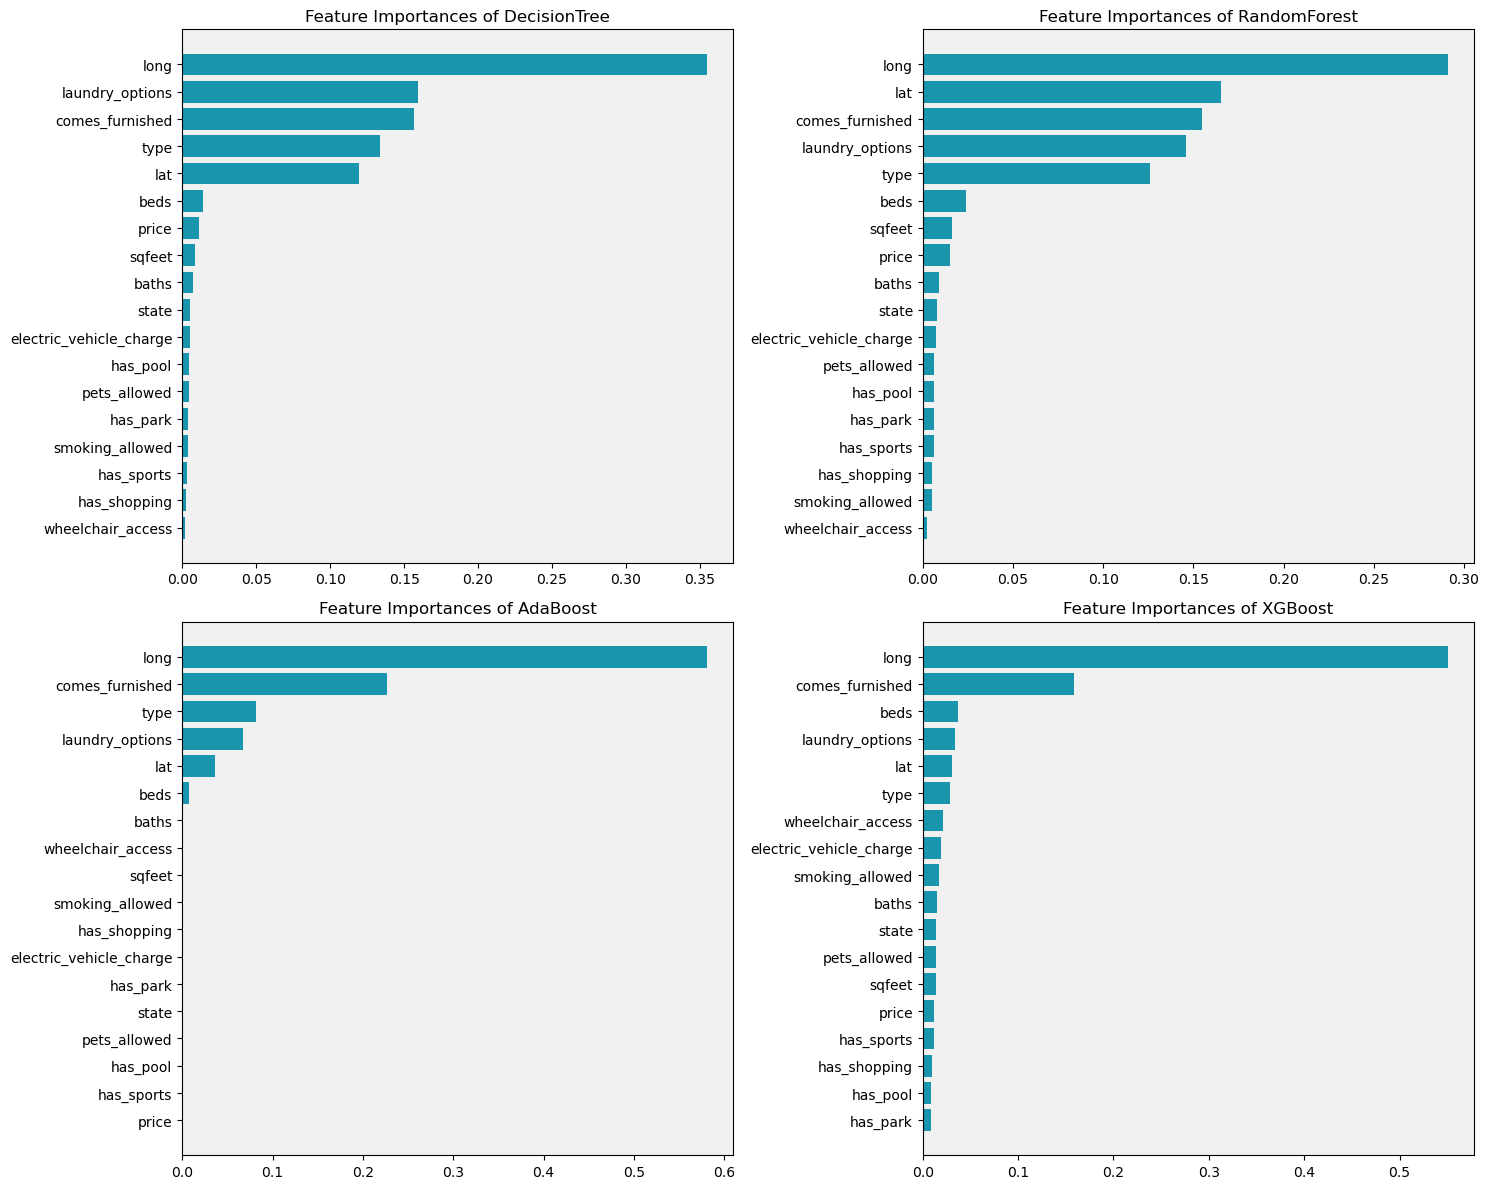

In [41]:
model_object_names.append("XGBoost")

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,12), dpi=100)

for idx, m in enumerate(best_models[3:]):
    importances = pd.Series({i:j for i,j in zip(train.columns, m.feature_importances_)}).sort_values()
    
    ax[idx//2, idx%2].set_facecolor("#f1f1f2")
    ax[idx//2, idx%2].barh(importances.index, importances.values, color="#1995ad")
    
    ax[idx//2, idx%2].set_title(f"Feature Importances of {model_object_names[3+idx]}")
    
plt.tight_layout()

## Results

In [42]:
results = pd.DataFrame(model_scores, index=["RMSE", "MAPE", "R2"]).T
results

,RMSE,MAPE,R2
ElasticNet,294.276641,0.205488,0.513960
SVR,273.210004,0.172073,0.581058
KNN,243.395759,0.142958,0.667504
DecisionTree,170.896674,0.080680,0.836081
RandomForest,129.500453,0.061730,0.905875
AdaBoost,295.198765,0.225453,0.510909
XGBoost,133.579251,0.073516,0.899853
